#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function
from IPython.display import Image

## Notes on the Concept of Neural Networks

In [1]:
#What is a derivative? 

#The derivative measures how much the function changes when the argument changes.
#The change in the function divided by the change in the argument.

#Derivative depends on the point where you are at right now. 
#In different points of the function, the derivative will be different. 
#Gradient is the derivative. 
#The direction of the derivative can tell you what’s happening with the function.
#Once you have the derivative, you can now try to local maximum or local minimum of the function. 

#We in many cases cannot find global max or min for many complexed functions.
#You never know if you’re at the global max or min, but there are tricks for it. 
#You can try to start from random parameters and see if you end up converging to the same point.

#Backprogrations is just a function to help you find derivatives. 
#The whole neural network is nothing but a bunch of functions chained together. 
#The way it works - you have a huge function, you divided it into pieces. 
#Our goal is to find, if we tweak X, how the whole function changes.

#The benefit of backpropagation is that we’re dividing a huge problem into smaller pieces. 
#Each piece is quite simple, you can write simple rules for how to calculate those derivatives.

## 1. Neural Networks

#### Visualizing the Data

In [2]:
datafile = 'ex4data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print ("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
def get_img(row):
    """
    Function that is handed a single np array with shape 1x400,
    creates an image object from it, and returns it
    
    Again, there are 400 pixels in each image. It was originally represented in a 400-dimensional vector 
    from the raw data, but we want to convert it into a grid of 20x20 matrix
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height) # converts 1x400 into 20x20
    return square.T

def display_data(numbers_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not numbers_to_display:
        numbers_to_display = random.sample(range(X.shape[0]), nrows*ncols) 
        # if "numbers_to_display" is not specified,
        # the randomly select 100 samples out of population of 5000 (the number of training examples)
    
    big_picture = np.zeros((height*nrows,width*ncols)) #big_picture.shape = (200, 200)
    """
    This part of the code below fills in the big_picture np.zeros with randomly selected training examples
    """
    irow, icol = 0, 0
    for idx in numbers_to_display: 
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = get_img(X[idx]) #running get_img for every training sample, in this case 100 samples
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        # don't completely understand this line above... 
        # but its basically broadcast input array from iimg into big_picture
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    
# logic of if not --> https://stackoverflow.com/questions/16739555/python-if-not-syntax
# scipy.misc.toimage --> Takes a numpy array and returns a PIL image
# shape[0] = # of rows | shape[1] = # of columns 

# big_picture.shape = (200,200)
# iimg.shape = (20,20)

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


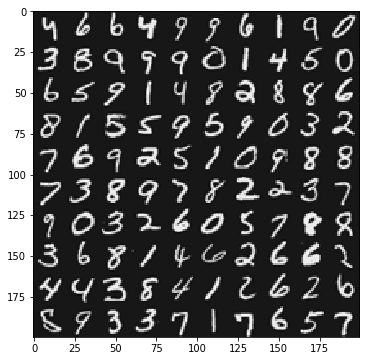

In [4]:
display_data()

#### Logic Behind Bias Units

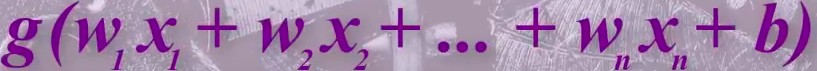

In [5]:
#Each neuron has a bias unit
#Biases is determining whether or not, or by how much a neuron will fire

#We pass the weighted sum + the bias term into the activation function

Image("Bias1.png", width=500, height=100)

In [6]:
#The model has a greater flexibility in fitting the data
#since it has a broader range in what values it considers activated or not

#In practice, we don't explicitly choose and control the biases
#Biases are learnable values in the network

#Good Youtube video <-- https://www.youtube.com/watch?v=HetFihsXSys

#### Model Representation

In [7]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex4weights.mat
datafile = 'ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 shape = 25 x 401
# Theta2 shape = 10 x 26

In [8]:
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0] #5000

In [9]:
#Because the optimize function assumes that the inputs are vectors, 
#We need to flatten our parameters from matrices into one long vector
#We then re-roll theparameters back when passing through the cost function
#Andrew Ng's explaination <-- https://www.coursera.org/learn/machine-learning/lecture/60Uxp/implementation-note-unrolling-parameters

def flatten_parameters(thetas_list):
    """
    Hand this function a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array
    """
    #copy of reach respective Theta array collapsed into one dimension
    flattened_list = [mytheta.flatten() for mytheta in thetas_list]
    
    #iterates through each Theta from Theta list
    combined = list(itertools.chain.from_iterable(flattened_list))
    
    #make sure that the len of combined Thetas is = to the len of number of variables in layers 
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + (hidden_layer_size+1)*output_layer_size

    #reshape to return shape of (n rows,1 column)
    #shape becomes (10285, 1)
    return np.array(combined).reshape((len(combined),1))

def reshape_parameters(flattened_array):
    
    #start pulling at 0 to (input_size+1)*hidden_size(401*25)
    #reshaping back to original (25x401)
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    
    #start pulling at (input_size+1)*hidden_size(401*25) until the end
    #reshaping back to original (10x26)
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

#.flatten() docs <-- https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.flatten.html
#.itertools.chain() docs <-- https://docs.python.org/2/library/itertools.html
# assert docs <-- https://www.programiz.com/python-programming/assert-statement

#### Feedforward and Cost Function

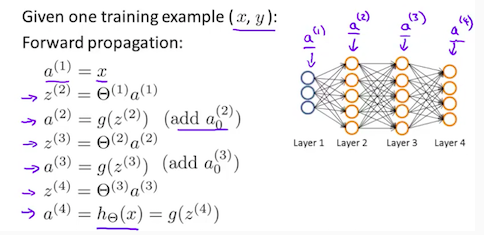

In [10]:
Image("Forward_Propagate1.png", width=500, height=300)

In [11]:
def propagate_forward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)): #iterate through each array of theta (so the len = 2) 
        Theta = Thetas[i]
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1: #basically if i == 1 | since len(Thetas) - 1 = 1
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

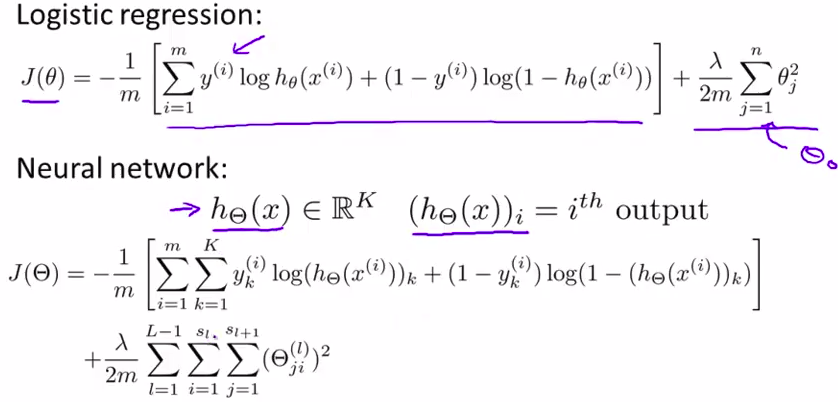

In [12]:
Image("Neural_Network_Cost_Function2.png", width=600, height=250)
# K is the number of distinct classes
# The hypothesis will output vectors that "K-dimensional"
# In the case of this number classification exercise, there are 10 classes corresponding to numbers 0-9
# The number of output units will = K

# The neural network cost function is a generalization of the logistic regression cost function
# Instead of having "1" logistic regression output unit, we may instead of "K" of them

In [13]:
def cost_function(flattened_mythetas,flattened_myX,myy,my_lambda=0.):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
    It loops over training points (recommended by the professor, as the linear
    algebra version is "quite complicated") and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
            with one non-zero entry corresponding to that iteration
        2) computes the cost given that y- vector and that training point
        3) accumulates all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    #First unroll the parameters
    mythetas = reshape_parameters(flattened_mythetas)
    
    #The unroll X
    myX = reshapeX(flattened_myX)
    
    #This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples
    
    # Computer the cost for each training point (rows in myX, already contain bias unit)
    for irow in range(m):
        myrow = myX[irow]
            
        # propagate_forward returns (zs, activations) for each layer
        # Returns (25x1) for the hidden layer and (10x1) for the output layer for "z" and "a" respectively
        
        # propagate_forward[-1][1] means returning the "activation for last (output) layer
        # propagate_forward[-1][1] is a (10,1) vector which repesents the the hypothesis for each possible y-value
        myhs = propagate_forward(myrow,mythetas)[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y-vector with 1 in the 10th spot (different from what the
        # homework suggests)
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        
        # Compute the cost for this point and y-vector
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # Accumulate the total cost
        total_cost += mycost
    
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(my_lambda)/(2*m)
        
    return total_cost + total_reg

In [14]:
#Computing cost using the loaded set of parameters Theta1 and Theta2,
myThetas = [ Theta1, Theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
print (cost_function(flatten_parameters(myThetas),flattenX(X),y))

0.28762916516131876


In [15]:
#Computing regularized cost function
myThetas = [ Theta1, Theta2 ]
print (cost_function(flatten_parameters(myThetas),flattenX(X),y,my_lambda=1.))

0.3844877962428938


## 2. Back Propagation

In [ ]:
#3Blue1Brown explaination:
# https://www.youtube.com/watch?v=Ilg3gGewQ5U
# Full neural network playlist:
# https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

#Back propagation is the algorithm for determining how a single training example
# would like to nudge the weights and biases. Not just in terms of whether they should go up and down
# but in terms of what relative proportion to those changes cause the most rapid decrease to the cost

In [16]:
def sigmoid_gradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

#### Random Initialization

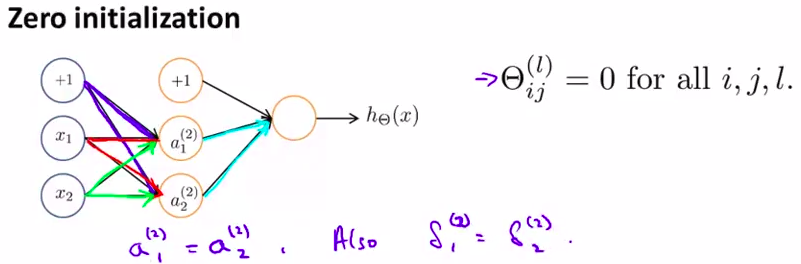

In [17]:
Image("Random_initialization1.png", width=600, height=250)

In [18]:
# Its possible to set initial theta to vector of all zeros for logistic regression.
# But we cannot do this for neural networks
# If we set initial thetas to all zeros, aftering multiplying them by the weights,
# you'll end up getting the same values in your hidden units

# You initialize theta to a random number between -epsilon and +epsilon

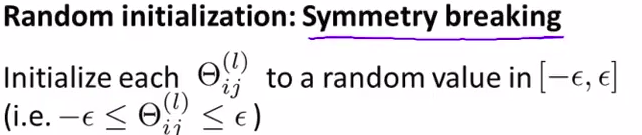

In [19]:
Image("Random_initialization2.png", width=400, height=150)

In [20]:
def random_thetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    
    #Creates matrix with random values between 0*1
    #Multiple by 2*epsilon - epsilon to get a random value between epsilon and -epsilon
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

# np.random.rand documentation <-- https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.rand.html

#### Backpropagation

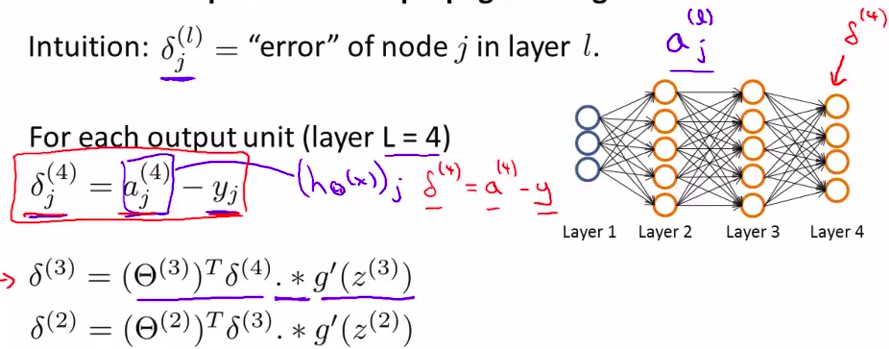

In [21]:
Image("Backpropagation1.png", width=600, height=250)

In [22]:
#The Delta is the error of node j in layer l
#You start with the output layer and work backwards
#  In Andrew Ng's example: delta4 = activation4 - the actual y unit
#  You work backwards all the way to the 2nd layer
#  There is no delta with layer one because we don't associate an error term with the input layer

In [ ]:
#In addition to the sigmoid function, there are many other activation functions that can be used
#Great article:
# https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

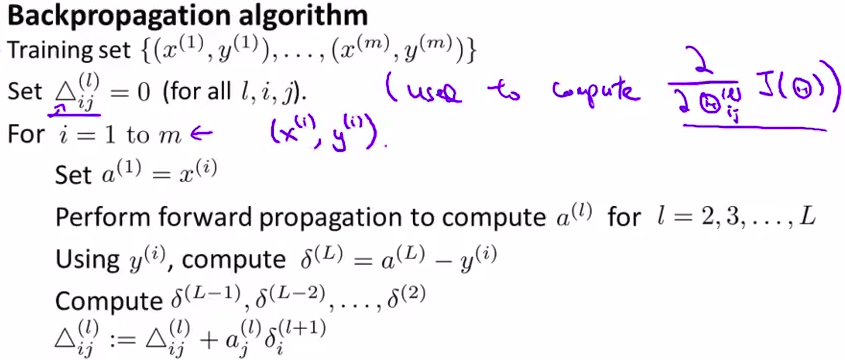

In [23]:
Image("Backpropagation2.png", width=600, height=300)

In [24]:
#Start by setting Delta to zero
#Delta will be used a accumulaters that we'll add things to, to compute the partial derivatives

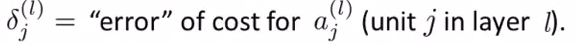

In [25]:
Image("Backpropagation3.png", width=400, height=100)
#We can think of Delta of the error of the activation value that we got for unit j in the lth layer

In [27]:
def backpropagation(mythetas_flattened,myX_flattened,myy,my_lambda=0.):
    #Unroll the parameters
    mythetas = reshape_parameters(mythetas_flattened)
    
    #Unroll X
    myX = reshapeX(myX_flattened)
    
    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagate_forward returns (zs, activations) for each layer excluding the input layer
        temp = propagate_forward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoid_gradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(my_lambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(my_lambda)/m)*mythetas[1][:,1:]
    
    return flatten_parameters([D1, D2]).flatten()

In [28]:
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = backpropagation(flatten_parameters(myThetas),flattenX(X),y,my_lambda=0.)
D1, D2 = reshape_parameters(flattenedD1D2)

#### Gradient Checking

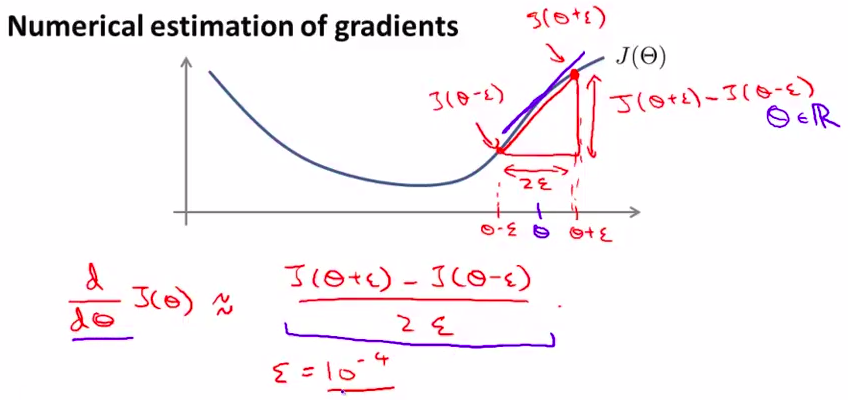

In [29]:
Image("Gradient_check1.png", width=600, height=300)
#You want to estimate the gradient by the slope of J(theta+epsilon)-J(theta-epsilon)

In [30]:
def check_gradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flatten_parameters(mythetas)
    flattenedDs = flatten_parameters(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = cost_function(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = cost_function(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [31]:
check_gradient(myThetas,[D1, D2],X,y)

Element: 5179. Numerical Gradient = 0.000024. BackProp Gradient = 0.000024.
Element: 1667. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 10169. Numerical Gradient = 0.000700. BackProp Gradient = 0.000700.
Element: 1279. Numerical Gradient = -0.000147. BackProp Gradient = -0.000147.
Element: 7841. Numerical Gradient = 0.000015. BackProp Gradient = 0.000015.
Element: 10197. Numerical Gradient = -0.000284. BackProp Gradient = -0.000284.
Element: 430. Numerical Gradient = 0.000013. BackProp Gradient = 0.000013.
Element: 10040. Numerical Gradient = -0.000947. BackProp Gradient = -0.000947.
Element: 9514. Numerical Gradient = 0.000067. BackProp Gradient = 0.000067.
Element: 3388. Numerical Gradient = -0.000007. BackProp Gradient = -0.000007.


#### Learning parameters

In [32]:
def train_NN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flatten_parameters(random_thetas())
    result = scipy.optimize.fmin_cg(cost_function, x0=randomThetas_unrolled, fprime=backpropagation, \
                               args=(flattenX(X),y,mylambda),maxiter=50,disp=True,full_output=True)
    return reshape_parameters(result[0])

In [33]:
learned_Thetas = train_NN()

         Current function value: 0.274571
         Iterations: 50
         Function evaluations: 117
         Gradient evaluations: 117


In [34]:
def predict_NN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = [1,2,3,4,5,6,7,8,9,10]
    output = propagate_forward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def compute_accuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predict_NN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print ("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [35]:
compute_accuracy(X,learned_Thetas,y)

Training set accuracy: 96.7%


In [36]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = train_NN(mylambda=10.)

         Current function value: 1.106292
         Iterations: 50
         Function evaluations: 108
         Gradient evaluations: 108


In [37]:
compute_accuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 93.0%
